# **Neural Collaborative Filtering**
___

## **A. Introduction**
___

Within this notebook, neural collaborative filtering will be presented as one approach for constructing collaborative recommendation system. In particular, this NCF (Neural Collaborative Filtering) conctruction will be made using `Torch`, although its logic could be implemented using others deep-learning platform such as `TensorFlow`, or `Trax`. For further information than this notebook, reader could refer to this paper : [neural-collaborative-filtering](https://paperswithcode.com/paper/neural-collaborative-filtering) as scientific source of this notebook, and also this repository : [neural-collaborative-filtering](https://github.com/yihong-chen/neural-collaborative-filtering) which inspire this project to be happened. 

The dataset which will be used for this project is [MovieLens1MDataset](https://grouplens.org/datasets/movielens/1m/), this is open source data collected by GroupLens research project. Consequently, 
people not only can use this project as reference for developing recommendation system, but also could used this code and match it with respective needs as long as proper citations are used. Furthermore, there will be three model used in this project, `Generalize Matrix Factorization (GMF)`, `Multi Layer Perceptron (MLP)`, and `Neural Matrix Factorization (NEUMF)`. All of the three models belong to group NCF Model.

As a disclaimer, this notebook is just for research purpose, in order to keep this notebook concise object oriented programming or classes will be used more. Reader whom have an intention to know the source code more deelpy can access the `script` part of this project. Moreover, the script part consist of `src folder` which is mainly consists of classses to be used by `api.py` and `train.py`. Training script `train.py` serves as script for deep-learning model training and the results will be saved in `folder checkpoints`. In addition api script, `api.py`, creates interface to be used by the model in machine learning infrascructure through api calls. Last but not least, `folder config` contains project configuration, and `folder runs` consist of training log files which can be accessed using `Tensorboard` to examine the training loss and performance over iteration.

## **B. Outline**
___

This notebook will be served as follows : 

    A. Introduction
    B. Outline
    C. Data Preparation
    D. Model Contruction
    E. Model Training & Evaluation
    F. Model Inference


Firstly, the introductory part explains the purpose of this project, mention the scientific and repository resources, and the dataset used. Secondly, the outline presents this notebook as a sequence of parts and to help readers access specific information. Thirdly, the data preparation process contains codes which function is to format the raw data before used as data for modelling the NCF model. Fourthly, model construction, this part contains code to build NCF model architectures and layers. Fifthly, constructed model from previous part will be trained and evaluated using recommendation system metrics in Model Training and Evaluation part. Sixthly and last, the NCF models will be used for inference process by using `user_id` and `num_reco` as input for calculating predicting recommendation.

Before start with data preparation process, configuration for this project must be loaded first to configurate classes within this project.

In [1]:
# load configuration
import sys
sys.path.append("../script/src/")
from utils import load_config

In [2]:
config_path = "../script/config/config.yaml"
config = load_config(file_path=config_path)
print(config.keys())

2024-01-05 22:18:53.182 | INFO     | utils:load_config:191 - LOADING PROJECT CONFIGURATION


dict_keys(['DatasetConfig', 'GMFConfig', 'MLPConfig', 'NEUMFConfig'])


As can be seen here, this project has three configuration (DatasetConfig, GMFConfig, MLPConfig, and NEUMFConfig). `DatasetConfig` is used to configure data preparation process, wherease the remaining three is served as each NCF model configuration. To check the configuration details, reader can access `config.yaml` in `script/config` directory.

## **C. Data Preparation**
___

As metioned before by section A, this project will use `MovieLens1MDataset`. This dataset comprises of `ratings.dat`, `users.dat`, and `movies.dat`, each of these data has its own function. For example `ratings.dat` records interactions between users and movies, wherease `users.dat` and `movies.dat` record metadata for each user and movies. However, only `ratings.dat` and `movies.dat` which will be used in this project. Furthermore, readers could checks `MovieLens1MDataset README file` in `data/raw/ml-1m` directory for detailed info regarding this dataset. 

In [3]:
import pandas as pd

# import interaction and metadata
interaction_data_dir = "../data/raw/ml-1m/ratings.dat"
movie_metadata_dir = "../data/raw/ml-1m/movies.dat"
interaction_data = pd.read_csv(interaction_data_dir, sep="::", header=None, names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')
movie_metadata = pd.read_csv(movie_metadata_dir, sep="::", header=None, names=["MovieID", "Title", "Genres"], engine='python', encoding='latin-1')

# basic cleaning
interaction_data.dropna(inplace=True)
interaction_data.drop_duplicates(inplace=True)
movie_metadata.dropna(inplace=True)
movie_metadata.drop_duplicates(inplace=True)

In [4]:
# examine raw data
print("=================== INTERACTION DATA ===================")
display(interaction_data.head())
print()
print(interaction_data.info())
print()
print("=================== MOVIE META DATA ===================")
display(movie_metadata.head())
print()
movie_metadata.info()
print()

=================== INTERACTION DATA ===================


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 38.2 MB
None

=================== MOVIE META DATA ===================


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 121.3+ KB



From the examined raw data, we have just above 1M interaction data and slightly less than 4000 movie data. Fortunatelly,  the data was cleaned, hence there is no need to do complex data cleaning for this project. However this cleaned data need to be further preprocessed to be ready for NCF modeling, thus class `NCFDataset` will be used. 

The `NCFDataset` class functions as data preprocessor, this class preprocess raw data into usable datas for NCF modelling. This picture below illustrate how this NCFDataset class functions.

<center><img src="../images/ncfdataset_class.png"/></center>
<center>Fig1. NCFDatasetClass Illustration</center>

There will be 8 usefull data for modeling generated by NCF Dataset
    
    1. mapped_data (pd.DataFrame) : raw data in which userIDs and movieIDs have been mapped into userIDs and movieIDs used for ncf modelling 
    2. mapped_dict (dictionary) : data which key and value pair consists of original userIDs and movieIDS, wherease the value contains userIDs and movieIDs for modelling
    3. user_pool (set) : data which contains unique userIDs model 
    4. item_pool (set) : data which contains unique movieIDs model
    5. negatives_interaction (pd.DataFrame) : data that provides information about movies that haven't been watched by all users, additionaly includes sampled movie from all unwatched movies configured by dataset config.  
    6. train_data (pd.DataFrame) : data that lists about movies that already been watched by all users, except the newest one. 
    7. test_data (pd.DataFrame) : data that lists about latest movies that already been watched by all users. 
    8. evaluation_data (list[torch.tensor]) : list of tensor that consists of positive interaction data and negative interaction data.

First of all, NCFDataset class need to be initialized using configuration, which has been loaded in previous section, further more method `process_raw_data` is called to turn raw interaction data into listed data above. If the process was done, processed data could be accessed by calling the data type as its attribute (ex. NCFDatasetObj.mapped_data, NCFDatasetObj.mapped_dict, etc). Finally processed data is saved in the form of pickle data for later usage. 

In [5]:
# import data generator
import sys
sys.path.append("../script")
from src.data import NCFDataset

# Create Data Generator using config["DatasetConfig"]
NCFDatasetObj = NCFDataset(config_data = config["DatasetConfig"])

# process data 
NCFDatasetObj.process_raw_data(raw_data=interaction_data)

# save data
NCFDatasetObj.save_dataset()

2024-01-05 22:19:43.180 | INFO     | src.data:__init__:19 - INITIALIZING NCF DATASET
2024-01-05 22:19:43.181 | INFO     | src.data:process_raw_data:40 - BEGIN PROCESSING RAW DATA
2024-01-05 22:19:43.182 | INFO     | src.data:_create_mapped_data:91 - BEGIN CREATING MAPPED DICT AND MAPPED DATA
2024-01-05 22:19:43.205 | INFO     | src.data:_create_mapped_data:92 - THE NUMBER OF UNIQUE USE IS 6040, AND UNIQUE ITEM ID IS 3706
2024-01-05 22:19:43.878 | INFO     | src.data:_create_mapped_data:115 - FINISH CREATING MAPPED DICT AND MAPPED DATA
2024-01-05 22:19:43.879 | INFO     | src.data:_binarize_interaction:139 - START BINARIZING INTERACTION DATA
2024-01-05 22:19:43.911 | INFO     | src.data:_binarize_interaction:142 - FINISH BINARIZING INTERACTION DATA
2024-01-05 22:19:43.912 | INFO     | src.data:_calculate_data_sparsity:149 - CALCULATE DATA SPARSITY
2024-01-05 22:19:43.925 | INFO     | src.data:_calculate_data_sparsity:157 - THE DATA DENSITY IS 0.0447 AND THE DATA SPARSITY IS 0.9553
2024-

In [6]:
# full dataset : data_generator.mapped_data
print("=================== MAPPED DATA ===================")
display(NCFDatasetObj.mapped_data.head())
print()
# data_generator.mapped_dict
print("=================== MAPPED DICTIONARY ===================")
print(NCFDatasetObj.mapped_dict.keys())
print()
# set of unique user
print("=================== MAPPED USER POOL ===================")
print(NCFDatasetObj.user_pool)
print()
# set of unique item
print("=================== MAPPED ITEM POOL ===================")
print(NCFDatasetObj.item_pool)
print()
# negatives dataset
print("=================== NEGATIVES DATASET ===================")
display(NCFDatasetObj.negatives_interaction.head())
print()
# train data
print("=================== TRAIN DATASET ===================")
display(NCFDatasetObj.train_data.head())
print()
# test data
print("=================== TEST DATASET ===================")
display(NCFDatasetObj.test_data.head())
print()
# evaluation data
print("=================== EVALUATION DATASET ===================")
print(f"Test user tensor size :  {NCFDatasetObj.evaluation_data[0].shape}")     # test_users tensor
print(f"Test item tensor size : {NCFDatasetObj.evaluation_data[1].shape}")     # test_items tensor
print(f"Test negative user tensor size : {NCFDatasetObj.evaluation_data[2].shape}")     # negative_users tensor
print(f"Test negative item tensor size : {NCFDatasetObj.evaluation_data[2].shape}")     # negative_item tensor

=================== MAPPED DATA ===================


,UserID,MovieID,Rating,Timestamp
0,0,0,1,978300760
1,0,1,1,978302109
2,0,2,1,978301968
3,0,3,1,978300275
4,0,4,1,978824291



=================== MAPPED DICTIONARY ===================
dict_keys(['userid_to_usermodelid', 'usermodelid_to_userid', 'itemid_to_itemmodelid', 'itemmodelid_to_itemid'])

=================== MAPPED USER POOL ===================
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 

,UserID,negative_items,negative_samples
0,0,"{53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6...","[1921, 1597, 1832, 1214, 2103, 111, 3376, 2296..."
1,1,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1979, 2829, 1840, 1424, 800, 1438, 970, 2360,..."
2,2,"{0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[1245, 321, 489, 573, 1246, 1985, 52, 1150, 36..."
3,3,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1585, 1163, 408, 2207, 1384, 257, 1198, 648, ..."
4,4,"{0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...","[3446, 3125, 566, 1503, 1512, 2863, 2199, 1411..."



=================== TRAIN DATASET ===================


,UserID,MovieID,Rating,Timestamp
0,0,0,1,978300760
1,0,1,1,978302109
2,0,2,1,978301968
3,0,3,1,978300275
4,0,4,1,978824291



=================== TEST DATASET ===================


,UserID,MovieID,Rating,Timestamp
25,0,25,1,978824351
66,1,66,1,978300174
232,2,207,1,978298504
235,3,208,1,978294282
258,4,222,1,978246585



=================== EVALUATION DATASET ===================
Test user tensor size :  torch.Size([6040])
Test item tensor size : torch.Size([6040])
Test negative user tensor size : torch.Size([597960])
Test negative item tensor size : torch.Size([597960])


As can be seen from the log process and data display, here MovieLens1MDataset has sparsity around 95%, which is a good data (less than 99% sparsity). 

## **D. MODEL CONSTRUCTION**
___

As mentioned within introductory part, there are three deep-learning model which will be used as recommendation architecture. There are : 1. Generalize Matrix Factorization, 2. Multi Layer Perceptron, and 3. Neural Matrix Factorization. All of these model was mentioned within [NCF-Paper](https://paperswithcode.com/paper/neural-collaborative-filtering). This model creation utilize three model classes, which is `GeneralizeMatrixFactorizationEngine`, `MultiLayerPerceptronEngine`, and `NeuMatrixFactorizationEngine` respectively for each kind of NCF model. These classes will be responsible for constructing layers, defining forward pass, initialize weight, and place the model whether in GPU or CPU. Furthermore, these classes inherit one common `Engine` class which functions mainly is to trains, evaluates, save, and load these models. In addition, `Engine` class also set the optimizer and loss function for training based on respective model configuration. All of these architectures will use sigmoid layer as final activation function, because implicit data train is used for this project  (interaction value only 0 and 1). On the other hand, if the train data is an explicit data (interaction value ranged between min and max) then this final layer could be changed into linear or ReLU instead. Here, the main differences between kind of NCF model presentend, started from the simplest one (GMF) until the most complex model (NEUMF)

**1. Generalized Matrix Factorization**
<center><img src="../images/gmf_schema.png"></center>
<center>Fig2. Generalize Matrix Factorization Layers</center>

The simplest from all neural collaborative filtering model, GMF consist of `User Embedding` layer, `Item Embedding` layer, which in this case is movie, and one dense `Ouput Layer` before going into `sigmoid` layer. Input to this model will be an integer representing user-id and movie-id respectively, thus the size of this embedding layer would be (num_user x embedding_size) for user embedding layer and (num_item x embedding_size) for item embedding layer.

Let p<sub>u</sub> and q<sub>i</sub> as user vector and item vector, thus mathematically GMF model represented as follows : 

$$
\hat{y}_{ui} = \sigma(h^{T}(p_{u} \odot q_{i}))\\
$$

$
where : \\
\hat{y}_{ui} = model\ prediction \\
\sigma = sigmoid\ activation\ function \\
h = dense\ output\ layer\ weights \\
p_{u} =  user\ embedding\ vector \\
q_{i} = item\ embedding\ vector \\
$

**2. Multi-Layer Perceptron** 
<center><img src="../images/mlp_schema.png"></center>
<center>Fig3. Multi-Layer Perceptron Layers</center>

Differ from GMF model, MLP model utilize more neural networks layer to predict the interaction. In addition from NCF Paper, batch normalization layer is added to maintain neuron within these MLP layers not saturated. Within this experiment there will be 5 neural network layers (4 hidden layers and 1 output layer) according to defined configuration, reader can experiments with this layers by changing the layers configuration in MLP model config. Instead of doing element wise multiplication here user vector and item vector is concated into one vector, thus the size is twice embedding size before being feeded into deep neural network. Mathematicaly MLP model could be illustrates as follows :

$$
z_{1} = [p_{u}, q_{i}] \\
\phi(z_{1}) = BatchNorm1D_2(ReLU_2(W^{T}_{2}z_{1} + b_{2})) \\
.... \\
\phi(z_{L-1}) = BatchNorm1D_L(ReLU_L(W^{T}_{L}z_{L-1} + b_{L})) \\
\hat{y}_{ui} = \sigma(h^{T}\phi(z_{L-1}))\\
$$

$
where : \\
\hat{y}_{ui} = model\ prediction \\
\sigma = sigmoid\ activation\ function \\
h = dense\ output\ layer\ weights \\
p_{u} =  user\ embedding\ vector \\
q_{i} = item\ embedding\ vector \\
\phi = neural\ network\ layer \\
[\ ] = concat\ operation
$


**3. Neural Matrix Factorization**
<center><img src="../images/neumf_schema.png"></center>
<center>Fig4. Neural Matrix Factorization Layers</center>

The last one is the most complicated between these three model, this model combines GMF model and MLP model which utilize different embedding layers within each model constituent. As can be seen from figure above, the output of the MLP part will be concatenated with the output of the GMF part. In addition, the concatenated vector will be feeded into the Dense output layer and finally enter the sigmoid layer to predict it's probability of occurence. Mathematically NEUMF model could be illustrated as follows:

$$
\phi^{GMF} = (p^{G}_{u} \odot q^{G}_{i})\\
\phi^{MLP} = BatchNorm1D_L(ReLU_L(W^{T}_{L}(BatchNorm1D_{L-1}(ReLU_{L-1}(...(BatchNorm1D_{2}(ReLU_{2}(W^{T}_2[p^{M}_2,q^{M}_2] + b_2)))...))+ b_{L-1}) + b_{L})) \\
\hat{y}_{ui} = \sigma(h^{T}([\phi^{GMF}, \phi^{MLP}]))
$$

$
where : \\
\hat{y}_{ui} = model\ prediction \\
\sigma = sigmoid\ activation\ function \\
h = dense\ output\ layer\ weights \\
p^{G}_{u} =  GMF\ user\ embedding\ vector \\
q^{G}_{i} = GMF\ item\ embedding\ vector \\
p^{M}_{u} =  MLP\ user\ embedding\ vector \\
q^{M}_{i} = MLP\ item\ embedding\ vector \\
\phi^{GMF} = GMF neural\ network\ layer \\
\phi^{MLP} = MLP neural\ network\ layer \\
[\ ] = concat\ operation
$

To start the model construction process, classes need to be imported and initialized using model configuration `(config['model_name'])`, and additional config `(DatasetModelConfig)` which comes from the dataset being used. 

In [7]:
import sys
sys.path.append("../script")
from src.gmf import GeneralizeMatrixFactorizationEngine
from src.mlp import MultiLayerPerceptronEngine
from src.neumf import NeuMatrixFactorizationEngine

In [8]:
DatasetModelConfig = {
    "NUM_USERS" : len(NCFDatasetObj.user_pool),
    "NUM_ITEMS" : len(NCFDatasetObj.item_pool),
    "MODEL_TYPE" : config['DatasetConfig']['MODEL_TYPE'],
}

print("=================== GMF MODEL ===================")
GMFEngine = GeneralizeMatrixFactorizationEngine(model_config = config['GMFConfig'], dataset_config = DatasetModelConfig)
print("=================== MLP MODEL ===================")
MLPEngine = MultiLayerPerceptronEngine(model_config = config['MLPConfig'], dataset_config = DatasetModelConfig)
print("=================== NEUMF MODEL =================")
NEUMFEngine = NeuMatrixFactorizationEngine(model_config = config['NEUMFConfig'], dataset_config = DatasetModelConfig)

2024-01-03 06:55:39.363 | INFO     | src.gmf:__init__:18 - BEGIN INITIALIZING MODEL GMF
2024-01-03 06:55:39.365 | INFO     | src.gmf:__init__:54 - CREATE GMF MODEL LAYER
2024-01-03 06:55:39.373 | INFO     | src.gmf:weight_initialization:97 - INITIALIZE GMF LAYERS WEIGHT
2024-01-03 06:55:39.376 | INFO     | src.gmf:__init__:66 - GMF MODEL LAYERS CREATED
2024-01-03 06:55:39.377 | INFO     | src.utils:detect_cuda:60 - DETECTING CUDA DEVICE
2024-01-03 06:55:39.379 | INFO     | src.utils:detect_cuda:66 - NO CUDA DEVICE DETECTED, USING CPU INSTEAD
2024-01-03 06:55:39.386 | INFO     | src.gmf:__init__:37 - FINISH INITIALIZING MODEL GMF
2024-01-03 06:55:39.394 | INFO     | src.mlp:__init__:19 - BEGIN INITIALIZING MODEl MLP
2024-01-03 06:55:39.395 | INFO     | src.mlp:__init__:56 - CREATE MLP MODEL LAYERS
2024-01-03 06:55:39.404 | INFO     | src.mlp:weight_initialization:109 - INITIALIZE MLP LAYERS WEIGHT
2024-01-03 06:55:39.408 | INFO     | src.mlp:__init__:75 - MLP MODEL LAYERS CREATED
2024-0

=================== GMF MODEL ===================
GeneralizeMatrixFactorization(
  (user_layer): Embedding(6040, 8)
  (item_layer): Embedding(3706, 8)
  (linear_layer): Linear(in_features=8, out_features=1, bias=False)
  (sigmoid_layer): Sigmoid()
)
=================== MLP MODEL ===================
MultiLayerPerceptron(
  (user_layer): Embedding(6040, 8)
  (item_layer): Embedding(3706, 8)
  (fc_layers): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layer): Linear(in_features=8, out_features=1, bias=False)
  (sigmoid_layer

## **E. MODEL TRAINING**
___

From the model architecture above, we could examine that the prediction value (y<sub>ui</sub>) will be in the range of 0 and 1 as a consequence of sigmoid layer utilization. Therefore, Binary Cross Entropy was selected as the loss function for optimizing these models. Moreover, calculated loss later will updates Embedding and Neuron parameters within the model in order to minimize the total loss and increase models performance. Mathematically, this loss function could be illustrated as :


$$
Loss = \displaystyle \sum_{(u,i) \in \upsilon^{-} \cup \upsilon} y_{ui}\log{\hat{y}_{ui}} + (1 - y_{ui})\log(1-\hat{y}_{ui})
$$

$
where : \\
\hat{y}_{ui} = model\ prediction \\
y_{ui} = interaction\ label \\
u, i = every\ user\ and\ item\ interactions \\
\upsilon^{-} = negative\ interactions \\
\upsilon = positive\ interactions \\
$

Here you'll find terms positive interaction as well as negative interaction. Positive interaction is acquired from the ratings dataset provided by MovieLens, in addition negative interaction data is generated data which represents the movies that hasn't been watched by each of the users. Furthermore, this technique is important due to NCF model doesn't utilize users interaction matrix. For this reason, to represent zero interaction NCF use negative interaction data for training sessions. The proportion of negative interaction data was configured in model configuration `NUM_NEGATIVES` which represent the ratio between positive interaction and negative interaction for every user listed in the training data.

Owing to this experiment will compare the performance from each type of NCF model, every hyper parameter will be equally configured. Here are the list of the hyper parameter which is used to train this three models : 
- Number of Epoch : 100
- Batch Size : 1024
- Optimizer : ADAM
- Learning Rage : 0.001
- Negative Interaction Proportion : 4
- L2 Regularization : 0.000001
- MLP Layers : [16, 32, 16, 8]
- Latent Dimension : 8
- Top_K performance measurement : 10 

Last but not least, after loss function selection and hyper-parameter definition model can be trained for defined epoch until ready for inference. This process will take some hours to finish.

In [9]:
import sys
sys.path.append("../script/")
from src.utils import train_model

In [10]:
train_model(model=GMFEngine, config=config['GMFConfig'], data_generator=NCFDatasetObj)

2024-01-03 06:56:16.649 | INFO     | src.utils:train_model:163 - CREATING DATA TRAIN LOADER | EPOCH 0 | NEGATIVE INTERACTION : 4 | BATCH SIZE : 1024
2024-01-03 07:00:35.192 | INFO     | src.utils:train_model:165 - DATA LOADER DONE, START TRAINING MODEL EPOCH 0
2024-01-03 07:00:36.178 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 0, LOSS 0.6970374584197998
2024-01-03 07:01:31.655 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 1000, LOSS 0.6933645009994507
2024-01-03 07:02:25.910 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 2000, LOSS 0.6928812861442566
2024-01-03 07:03:21.620 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 3000, LOSS 0.6930720806121826
2024-01-03 07:04:19.184 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 4000, LOSS 0.45462775230407715
2024-01-03 07:05:09.692 | INFO     | src.utils:train_model:170 - EPOCH 0 DONE, START EVALUATING MODEL
2024-01-03 07:05:11

In [11]:
train_model(model=MLPEngine, config=config['MLPConfig'], data_generator=NCFDatasetObj)

2024-01-03 11:03:40.928 | INFO     | src.utils:train_model:163 - CREATING DATA TRAIN LOADER | EPOCH 0 | NEGATIVE INTERACTION : 4 | BATCH SIZE : 1024
2024-01-03 11:05:43.422 | INFO     | src.utils:train_model:165 - DATA LOADER DONE, START TRAINING MODEL EPOCH 0
2024-01-03 11:05:43.873 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 0, LOSS 1.0381293296813965
2024-01-03 11:06:12.760 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 1000, LOSS 0.43872278928756714
2024-01-03 11:06:42.620 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 2000, LOSS 0.41689571738243103
2024-01-03 11:07:09.714 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 3000, LOSS 0.35084131360054016
2024-01-03 11:07:39.247 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 4000, LOSS 0.36376678943634033
2024-01-03 11:08:03.637 | INFO     | src.utils:train_model:170 - EPOCH 0 DONE, START EVALUATING MODEL
2024-01-03 11:08

In [12]:
train_model(model=NEUMFEngine, config=config['NEUMFConfig'], data_generator=NCFDatasetObj)

2024-01-03 17:11:47.515 | INFO     | src.utils:train_model:163 - CREATING DATA TRAIN LOADER | EPOCH 0 | NEGATIVE INTERACTION : 4 | BATCH SIZE : 1024
2024-01-03 17:14:07.646 | INFO     | src.utils:train_model:165 - DATA LOADER DONE, START TRAINING MODEL EPOCH 0
2024-01-03 17:14:08.043 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 0, LOSS 1.1439437866210938
2024-01-03 17:14:41.737 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 1000, LOSS 0.41758909821510315
2024-01-03 17:15:18.153 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 2000, LOSS 0.40946319699287415
2024-01-03 17:15:52.716 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 3000, LOSS 0.36214303970336914
2024-01-03 17:16:27.835 | INFO     | src.engine:train_an_epoch:100 - [TRAINING EPOCH 0] BATCH 4000, LOSS 0.3600558936595917
2024-01-03 17:16:57.797 | INFO     | src.utils:train_model:170 - EPOCH 0 DONE, START EVALUATING MODEL
2024-01-03 17:16:

The long training have been done, moreover logs data which have been recorded in tensorboardX need to be analyze further in order to differentiate performance between these three model. There are 4 data being recorded here 

1. `LOSS/PER_BATCH` : loss value per batch training from the start of the training until the end
2. `LOSS/PER_EPOCH` : total loss per epoch (accumulation of bathes) from the start of the training until the end
3. `PERFORMANCE/HIT_RATIO` : hit ratio evaluation using test data for every epoch
4. `PERFORMANCE/NDCG` : ndcg evaluation using test data for every epoch 

These four log data will be compared, firstly saved logs need to be loaded.

In [84]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

gmf_log_dir = "runs/GMF_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_MODELTYPE-IMPLICIT/events.out.tfevents.1704239739.SAT-PC"
mlp_log_dir = "runs/MLP_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT/events.out.tfevents.1704239739.SAT-PC" 
neumf_log_dir = "runs/NEUMF_FACTORGMF-8_FACTORMLP-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT/events.out.tfevents.1704239739.SAT-PC"

gmf_event = event_accumulator.EventAccumulator(gmf_log_dir)
mlp_event = event_accumulator.EventAccumulator(mlp_log_dir)
neumf_event = event_accumulator.EventAccumulator(neumf_log_dir)

gmf_event.Reload()
mlp_event.Reload()
neumf_event.Reload()

In [85]:
# load data GMF
gmf_loss_per_batch = [scalar.value for scalar in gmf_event.Scalars('LOSS/PER_BATCH')]
gmf_loss_per_epoch = [scalar.value for scalar in gmf_event.Scalars('LOSS/PER_EPOCH')]
gmf_hit_ratio = [scalar.value for scalar in gmf_event.Scalars('PERFORMANCE/HIT_RATIO')]
gmf_ndcg = [scalar.value for scalar in gmf_event.Scalars('PERFORMANCE/NDCG')]

# load data MLP
mlp_loss_per_batch = [scalar.value for scalar in mlp_event.Scalars('LOSS/PER_BATCH')]
mlp_loss_per_epoch = [scalar.value for scalar in mlp_event.Scalars('LOSS/PER_EPOCH')]
mlp_hit_ratio = [scalar.value for scalar in mlp_event.Scalars('PERFORMANCE/HIT_RATIO')]
mlp_ndcg = [scalar.value for scalar in mlp_event.Scalars('PERFORMANCE/NDCG')]

# load data NEUMF
neumf_loss_per_batch = [scalar.value for scalar in neumf_event.Scalars('LOSS/PER_BATCH')]
neumf_loss_per_epoch = [scalar.value for scalar in neumf_event.Scalars('LOSS/PER_EPOCH')]
neumf_hit_ratio = [scalar.value for scalar in neumf_event.Scalars('PERFORMANCE/HIT_RATIO')]
neumf_ndcg = [scalar.value for scalar in neumf_event.Scalars('PERFORMANCE/NDCG')]

In [133]:
import pandas as pd

# create dataframe for plot
resume_data1 = pd.DataFrame({'batch': list(range(len(gmf_loss_per_batch))),
                            'gmf_loss' : gmf_loss_per_batch,
                            'mlp_loss' : mlp_loss_per_batch,
                            'neumf_loss': neumf_loss_per_batch})
resume_data1 = pd.melt(resume_data1, id_vars=['batch'], var_name='Model Loss', value_name='Loss')

resume_data2 = pd.DataFrame({'epoch': list(range(len(gmf_loss_per_epoch))),
                            'gmf_loss' : gmf_loss_per_epoch,
                            'gmf_hit_ratio' : gmf_hit_ratio,
                            'gmf_ndcg': gmf_ndcg,
                            'mlp_loss' : mlp_loss_per_epoch,
                            'mlp_hit_ratio' : mlp_hit_ratio,
                            'mlp_ndcg' : mlp_ndcg,
                            'neumf_loss': neumf_loss_per_epoch,
                            'neumf_hit_ratio' : neumf_hit_ratio,
                            'neumf_ndcg' : neumf_ndcg})
resume_data2 = pd.melt(resume_data2, id_vars=['epoch'])

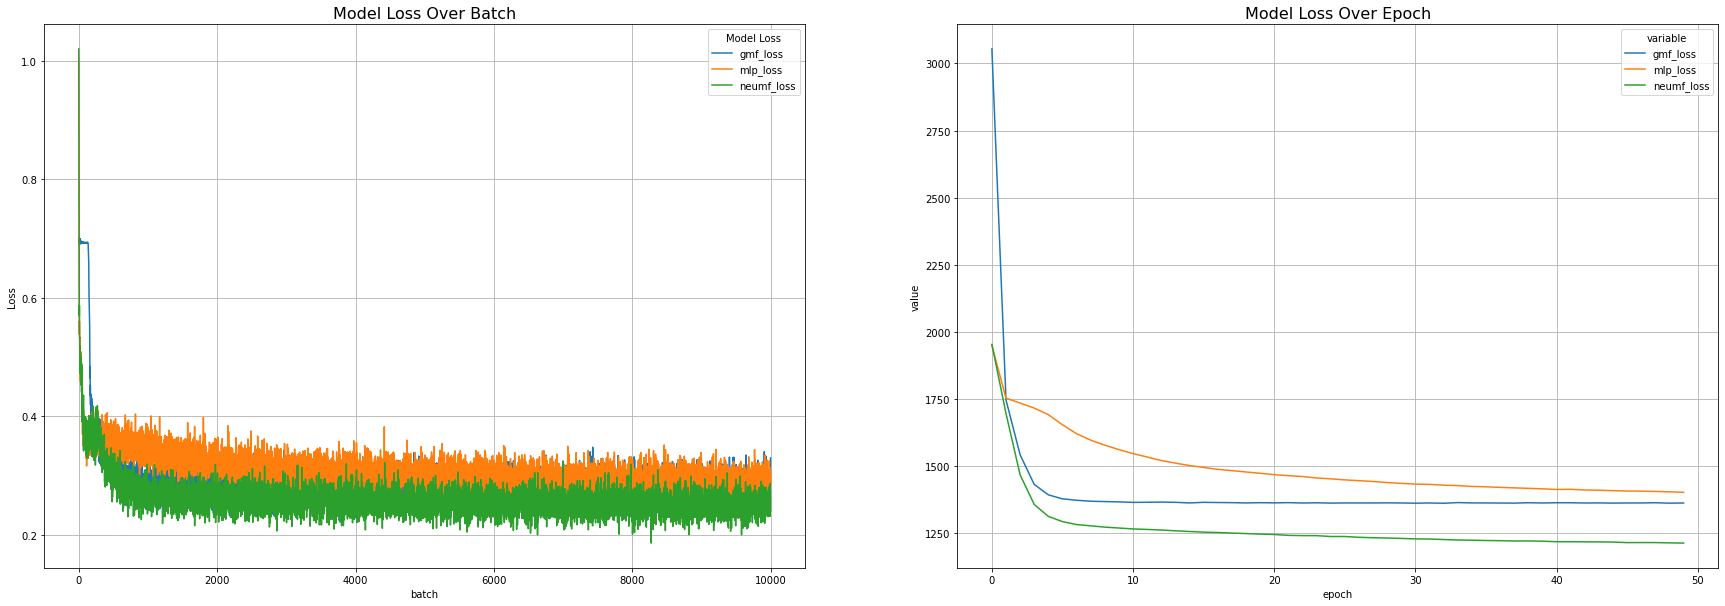

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))
sns.lineplot(data=resume_data1,
             x='batch',
             y='Loss',
             hue='Model Loss',
             ax=ax[0])
sns.lineplot(data=resume_data2[resume_data2['variable'].str.contains("_loss")],
             x='epoch',
             y='value',
             hue='variable',
             ax=ax[1])
ax[0].set_title("Model Loss Over Batch", fontsize=16)
ax[1].set_title("Model Loss Over Epoch", fontsize=16)
ax[0].grid()
ax[1].grid()
plt.show()

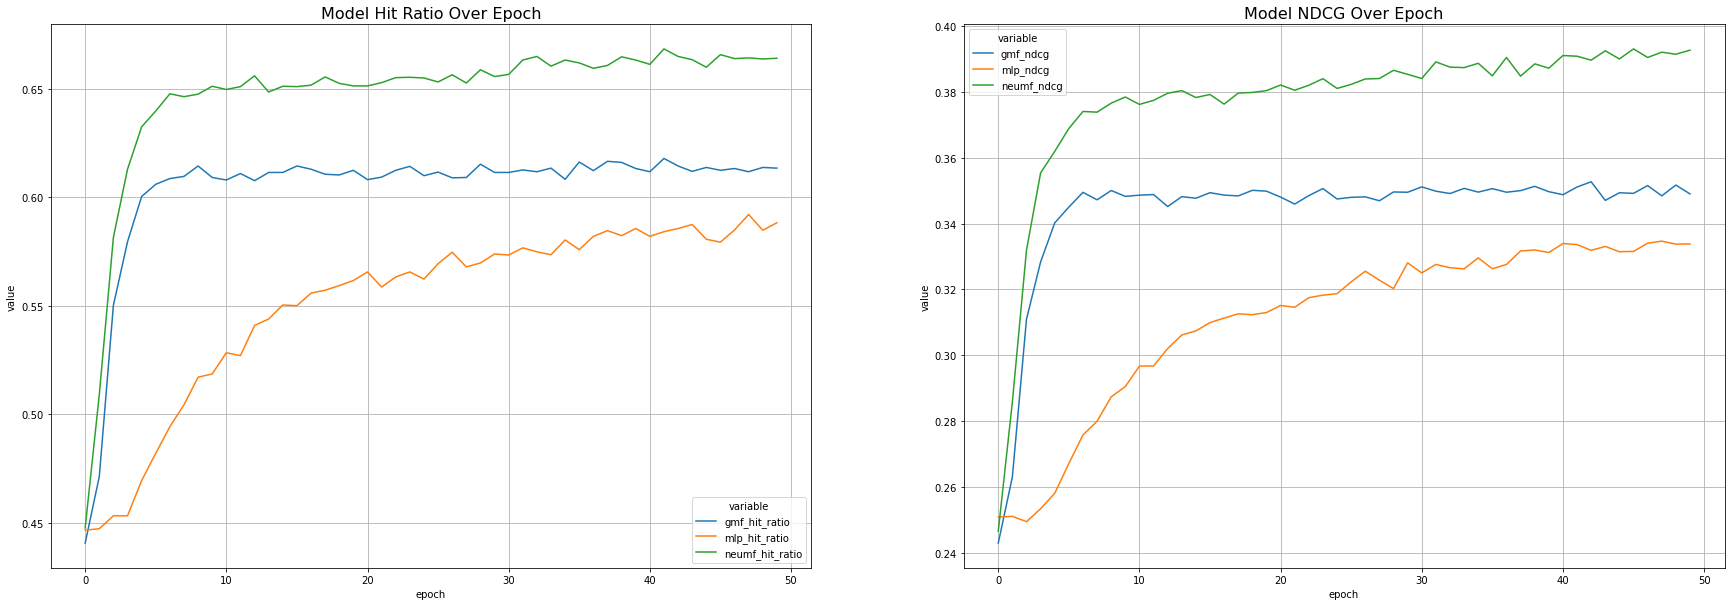

In [151]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))
sns.lineplot(data=resume_data2[resume_data2['variable'].str.contains("_hit_ratio")],
             x='epoch',
             y='value',
             hue='variable',
             ax=ax[0])
sns.lineplot(data=resume_data2[resume_data2['variable'].str.contains("_ndcg")],
             x='epoch',
             y='value',
             hue='variable',
             ax=ax[1])
ax[0].set_title("Model Hit Ratio Over Epoch", fontsize=16)
ax[1].set_title("Model NDCG Over Epoch", fontsize=16)
ax[0].grid()
ax[1].grid()
plt.show()

## **F. MODEL INFERENCE**
___

After these three model been trained and evaluated, next process is to make a prediction. Firstly, saved model need to be loaded into this environment prior to making a prediction. Consequently, the best model, which was trained over 50 epoch, will be used. Those model name is : 
1. GMF : `GMF_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_MODELTYPE-IMPLICIT_EPOCH49_HR0.6134_NDCG0.3490.model`
2. MLP : `MLP_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT_EPOCH49_HR0.5882_NDCG0.3339.model`
3. NEUMF :  `NEUMF_FACTORGMF-8_FACTORMLP-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT_EPOCH49_HR0.6641_NDCG0.3927.model`

Hence, several class engine and configuration needed to be establish first before model being loaded into the environment.

In [10]:
import sys
sys.path.append("../script/")
from src.utils import get_recommendation, resume_checkpoint
from src.gmf import GeneralizeMatrixFactorizationEngine
from src.mlp import MultiLayerPerceptronEngine
from src.neumf import NeuMatrixFactorizationEngine

DatasetModelConfig = {
    "NUM_USERS" : len(NCFDatasetObj.user_pool),
    "NUM_ITEMS" : len(NCFDatasetObj.item_pool),
    "MODEL_TYPE" : config['DatasetConfig']['MODEL_TYPE'],
}

In [11]:
# list pretrain model
gmf_pretrain_model = "checkpoints/gmf/GMF_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_MODELTYPE-IMPLICIT_EPOCH49_HR0.6134_NDCG0.3490.model"
mlp_pretrain_model = "checkpoints/mlp/MLP_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT_EPOCH49_HR0.5882_NDCG0.3339.model"
neumf_pretrain_model = "checkpoints/neumf/NEUMF_FACTORGMF-8_FACTORMLP-8_NEG-4_BS-1024_REGL2-1e-06_LAYERS-1632168_MODELTYPE-IMPLICIT_EPOCH49_HR0.6641_NDCG0.3927.model"

# create GMF model object
GMFEngine = GeneralizeMatrixFactorizationEngine(model_config = config['GMFConfig'], dataset_config = DatasetModelConfig)
resume_checkpoint(model = GMFEngine.model, model_dir = gmf_pretrain_model)

# create MLP model object
MLPEngine = MultiLayerPerceptronEngine(model_config = config['MLPConfig'], dataset_config = DatasetModelConfig)
resume_checkpoint(model = MLPEngine.model, model_dir = mlp_pretrain_model)

# create NeuMLP model object
NEUMFEngine = NeuMatrixFactorizationEngine(model_config = config['NEUMFConfig'], dataset_config = DatasetModelConfig)
resume_checkpoint(model = NEUMFEngine.model, model_dir = neumf_pretrain_model)

2024-01-05 22:21:11.185 | INFO     | src.gmf:__init__:18 - BEGIN INITIALIZING MODEL GMF
2024-01-05 22:21:11.187 | INFO     | src.gmf:__init__:54 - CREATE GMF MODEL LAYER
2024-01-05 22:21:11.191 | INFO     | src.gmf:weight_initialization:97 - INITIALIZE GMF LAYERS WEIGHT
2024-01-05 22:21:11.194 | INFO     | src.gmf:__init__:66 - GMF MODEL LAYERS CREATED
2024-01-05 22:21:11.194 | INFO     | src.utils:detect_cuda:60 - DETECTING CUDA DEVICE
2024-01-05 22:21:11.196 | INFO     | src.utils:detect_cuda:66 - NO CUDA DEVICE DETECTED, USING CPU INSTEAD
2024-01-05 22:21:11.201 | INFO     | src.gmf:__init__:37 - FINISH INITIALIZING MODEL GMF
2024-01-05 22:21:11.204 | INFO     | src.utils:resume_checkpoint:90 - LOADING MODEL STATEDICT FROM : checkpoints/gmf/GMF_FACTOR-8_NEG-4_BS-1024_REGL2-1e-06_MODELTYPE-IMPLICIT_EPOCH49_HR0.6134_NDCG0.3490.model
2024-01-05 22:21:11.219 | INFO     | src.utils:resume_checkpoint:93 - MODEL STATEDICT LOADED
2024-01-05 22:21:11.220 | INFO     | src.mlp:__init__:19 - BE

GeneralizeMatrixFactorization(
  (user_layer): Embedding(6040, 8)
  (item_layer): Embedding(3706, 8)
  (linear_layer): Linear(in_features=8, out_features=1, bias=False)
  (sigmoid_layer): Sigmoid()
)
MultiLayerPerceptron(
  (user_layer): Embedding(6040, 8)
  (item_layer): Embedding(3706, 8)
  (fc_layers): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layer): Linear(in_features=8, out_features=1, bias=False)
  (sigmoid_layer): Sigmoid()
)
NeuMatrixFactorization(
  (user_layer_mlp): Embedding(6040, 8)
  (item_layer_mlp): Em

As can be seen from the log above, model is already loaded and ready to make a prediction for every user registered into the model.

In [19]:
# recommendation using GMF model
reco_df_gmf = get_recommendation(user_id = 1,
                             num_reco=15,
                             metadata=movie_metadata,
                             user_column_name='UserID',
                             item_column_name='MovieID',
                             model_object=GMFEngine,
                             data_generator_object=NCFDatasetObj)
reco_df_gmf

,MovieID,Title,Genres,proba_score
0,3071,Stand and Deliver (1987),Drama,0.976063
1,608,Fargo (1996),Crime|Drama|Thriller,0.971235
2,3468,"Hustler, The (1961)",Drama,0.951086
3,16,Casino (1995),Drama|Thriller,0.932380
4,1801,"Man in the Iron Mask, The (1998)",Action|Drama|Romance,0.894811
5,1175,Delicatessen (1991),Comedy|Sci-Fi,0.892398
6,73,"Misérables, Les (1995)",Drama|Musical,0.880140
7,2717,Ghostbusters II (1989),Comedy|Horror,0.876270
8,2124,"Addams Family, The (1991)",Comedy,0.866850
9,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama,0.865950


In [13]:
# recommendation using MLP model
reco_df_mlp = get_recommendation(user_id = 1,
                             num_reco=15,
                             metadata=movie_metadata,
                             user_column_name='UserID',
                             item_column_name='MovieID',
                             model_object=MLPEngine,
                             data_generator_object=NCFDatasetObj)
reco_df_mlp

,MovieID,Title,Genres,proba_score
0,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.993248
1,938,Gigi (1958),Musical,0.990735
2,1217,Ran (1985),Drama|War,0.985025
3,3107,Backdraft (1991),Action|Drama,0.984274
4,1784,As Good As It Gets (1997),Comedy|Drama,0.958789
5,1968,"Breakfast Club, The (1985)",Comedy|Drama,0.958368
6,2804,"Christmas Story, A (1983)",Comedy|Drama,0.957257
7,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller,0.956844
8,2717,Ghostbusters II (1989),Comedy|Horror,0.956595
9,1529,Nowhere (1997),Drama,0.952735


In [20]:
# recommendation using NEUMF model
reco_df_neumf = get_recommendation(user_id = 1,
                             num_reco=15,
                             metadata=movie_metadata,
                             user_column_name='UserID',
                             item_column_name='MovieID',
                             model_object=NEUMFEngine,
                             data_generator_object=NCFDatasetObj)
reco_df_neumf

,MovieID,Title,Genres,proba_score
0,3260,Howards End (1992),Drama,0.995792
1,16,Casino (1995),Drama|Thriller,0.992864
2,860,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",Comedy,0.992466
3,2124,"Addams Family, The (1991)",Comedy,0.992083
4,1442,Prefontaine (1997),Drama,0.990536
5,1252,Chinatown (1974),Film-Noir|Mystery|Thriller,0.988900
6,459,"Getaway, The (1994)",Action,0.987828
7,1684,Mrs. Dalloway (1997),Romance,0.984779
8,2136,"Nutty Professor, The (1963)",Comedy,0.983652
9,904,Rear Window (1954),Mystery|Thriller,0.982586
